In [1]:
'''
Inspired from https://github.com/GunhoChoi/Kind-PyTorch-Tutorial/blob/master/07_Denoising_Autoencoder/Denoising_Autoencoder.ipynb
'''

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io, transform
import os
import pickle
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
import cv2
from skimage.transform import resize
path = os.path.abspath('./data/allendata')
genes = [f for f in os.listdir(path)]

data_list=[]
geneNb = 0
for i in range(geneNb, len(genes)):
    gene=genes[i]
    try:
        GO=GO_terms[gene]
    except:
        GO=[]
    gene_path = path+'/'+gene
    genes_images = [f for f in os.listdir(gene_path)]
    for gene_image in genes_images:
        file = gene_path+'/'+gene_image
        img = cv2.imread(file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #reshape images to same dimensions
        img=resize(gray_img, (120,240), anti_aliasing=True, mode='constant') #resize all images to 120x240
        img=np.asarray(img, dtype=float)
        data_list.append(img)
    if geneNb%1000==0:
        print(geneNb)
    geneNb += 1

images_array=np.asarray(data_list)
del data_list

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [4]:
class Comb_Dataset(Dataset):

    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        sample = {'image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        transformed_image = torch.from_numpy(image)
        unsqueezed_image = torch.unsqueeze(transformed_image,0) #add a dimension with value 1 to represent colour
        float_img=unsqueezed_image.float()
        return {'image': float_img}


In [5]:
#preparing the data and batches
transformed_data = Comb_Dataset(images = images_array, 
                                transform = ToTensor())
#del images_array

In [8]:
class SmallEncoder(nn.Module):
    def __init__(self):
        super(SmallEncoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.layer3 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
                        nn.Conv2d(16,1,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out, indices1 = self.pool(out)
        out = self.layer2(out)
        out, indices2 = self.pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out, [indices1, indices2]

encoder = SmallEncoder().to(device)


class SmallDecoder(nn.Module):
    def __init__(self):
        super(SmallDecoder,self).__init__()
        self.first_conv = nn.Sequential(
                        nn.ConvTranspose2d(1,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.unpool = nn.MaxUnpool2d(2,2)
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(16,1,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
    def forward(self,x, indices):
        out = x.view(x.size(0),1,30,60)
        out = self.first_conv(out)
        out = self.unpool(out, indices[1])
        out = self.layer1(out)
        out = self.unpool(out, indices[0])
        out = self.layer2(out)
        out = self.layer3(out)
        return out

decoder = SmallDecoder().to(device)

In [6]:
# Encoder 

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.layer3 = nn.Sequential(
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,16,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
                        nn.Conv2d(16,1,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out, indices1 = self.pool(out)
        out = self.layer2(out)
        out, indices2 = self.pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out, [indices1, indices2]

encoder = Encoder().to(device)


In [7]:
# Decoder 

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.first_conv = nn.Sequential(
                        nn.ConvTranspose2d(1,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
        )
        self.unpool = nn.MaxUnpool2d(2,2)
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(16,1,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(1),
        )
        
    def forward(self,x, indices):
        out = x.view(x.size(0),1,30,60)
        out = self.first_conv(out)
        out = self.unpool(out, indices[1])
        out = self.layer1(out)
        out = self.unpool(out, indices[0])
        out = self.layer2(out)
        out = self.layer3(out)
        return out

decoder = Decoder().to(device)

In [8]:
batch_size =100

def train_validation_split(data, p):
    import random
    idx=np.arange(len(data))
    random.shuffle(idx)
    train_data=[]
    for i in idx[:int(p*len(data))]:
        train_data.append(data[i])
    valid_data=[]
    for i in idx[int(p*len(data)):]:
        valid_data.append(data[i])
    return (train_data, valid_data)
train_data, valid_data = train_validation_split(transformed_data, 0.8)
del transformed_data

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader  = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
del train_data, valid_data


In [9]:
random_seed = 1
torch.backends.cudnn.enabled = False #setting off non-deterministic algorithms
torch.manual_seed(random_seed)

# Set Hyperparameters

epoch = 10
learning_rate = 0.01
cur_epoch=0

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)


In [10]:
def add_noise(batch_img):
    shape=batch_img.size()
    for i in range(shape[0]):
        length=shape[2]*shape[3]
        idx=np.ones(length)
        random_idx=np.random.choice(np.arange(length), int(length*0.3))
        idx[random_idx]=0
        idx=idx.reshape([shape[2],shape[3]])
        batch_img[i,0,:,:]=batch_img[i,0,:,:]*torch.from_numpy(idx).float().to(device)
    return batch_img
    

Train Epoch: 0 [0/17437 (0%)]	Loss: 0.000085
Train Epoch: 0 [10/17437 (6%)]	Loss: 0.000114
Train Epoch: 0 [20/17437 (11%)]	Loss: 0.000086
Train Epoch: 0 [30/17437 (17%)]	Loss: 0.000104
Train Epoch: 0 [40/17437 (23%)]	Loss: 0.000076
Train Epoch: 0 [50/17437 (29%)]	Loss: 0.000162
Train Epoch: 0 [60/17437 (34%)]	Loss: 0.000094
Train Epoch: 0 [70/17437 (40%)]	Loss: 0.000073
Train Epoch: 0 [80/17437 (46%)]	Loss: 0.000075
Train Epoch: 0 [90/17437 (51%)]	Loss: 0.000106
Train Epoch: 0 [100/17437 (57%)]	Loss: 0.000083
Train Epoch: 0 [110/17437 (63%)]	Loss: 0.000151
Train Epoch: 0 [120/17437 (69%)]	Loss: 0.000151
Train Epoch: 0 [130/17437 (74%)]	Loss: 0.000107
Train Epoch: 0 [140/17437 (80%)]	Loss: 0.000071
Train Epoch: 0 [150/17437 (86%)]	Loss: 0.000072
Train Epoch: 0 [160/17437 (91%)]	Loss: 0.000122
Train Epoch: 0 [170/17437 (97%)]	Loss: 0.000121
Average test loss: 8.72935908608435e-05
Train Epoch: 1 [0/17437 (0%)]	Loss: 0.000094
Train Epoch: 1 [10/17437 (6%)]	Loss: 0.000089
Train Epoch: 1 [20

KeyboardInterrupt: 

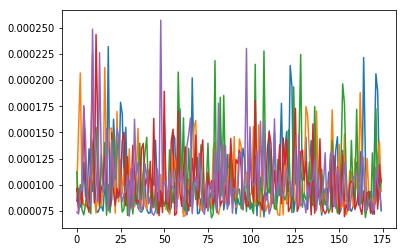

In [15]:
for i in range(epoch):
    loss_followup=[]
    encoder.train()
    decoder.train()
    for batch_idx, data in enumerate(train_loader):
        image = data["image"].to(device)
        image_n = add_noise(image)
        optimizer.zero_grad()
        output, indices = encoder(image_n)
        output = decoder(output, indices)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        loss_followup.append(loss.item())
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                i, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    plt.plot(loss_followup)
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        test_loss = 0
        correct = 0
        test_loss_followup=[]
        for batch_idx, data in enumerate(valid_loader):
            image = data["image"].to(device)
            image_n = add_noise(image)
            output, indices = encoder(image_n)
            output = decoder(output, indices)
            loss = loss_func(output,image)
            test_loss_followup.append(loss.item())

        test_loss = np.asarray(test_loss_followup).mean()
        print('Average test loss: '+str(test_loss))
                
    torch.save([encoder,decoder, loss_followup, test_loss_followup],'./data/autoencoder.pkl')


In [16]:
# save and load model

try:
    [encoder,decoder, loss_followup, test_loss_followup] = torch.load('./data/autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass



--------model restored--------



In [17]:
enc_output, indices = encoder(image_n[:10,:,:,:])
dec_output = decoder(enc_output, indices)


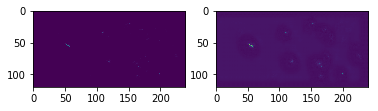

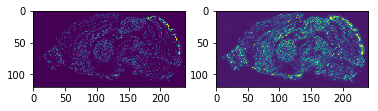

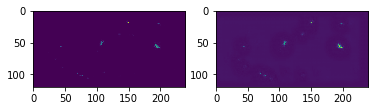

In [18]:
img=image.cpu().detach().numpy()
out=dec_output.cpu().detach().numpy()
fig,[ax1,ax2]=plt.subplots(1,2)
ax1.imshow(img[5,0,:,:])
ax2.imshow(out[5,0,:,:])

fig,[ax1,ax2]=plt.subplots(1,2)
ax1.imshow(img[6,0,:,:])
ax2.imshow(out[6,0,:,:])

fig,[ax1,ax2]=plt.subplots(1,2)
ax1.imshow(img[7,0,:,:])
ax2.imshow(out[7,0,:,:])


In [8]:
# save and load model

try:
    encoder,decoder, a,b = torch.load('./data/small_autoencoder.pkl')
#    [encoder,decoder, a] = torch.load('./data/deno_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass



--------model restored--------



In [9]:
batch_size =30

#preparing the data and batches
train_loader = torch.utils.data.DataLoader(transformed_data, batch_size=batch_size, shuffle=False)
del transformed_data

In [10]:
orig_batches=[]
out_batches=[]
enc_batches=[]
with torch.no_grad():
    for batch_idx, data in enumerate(train_loader):
        image = data["image"].to(device)
        orig_batches.append(image)
        enc_output, indices = encoder(image)
        enc_batches.append(enc_output)
        output=decoder(enc_output, indices)
        out_batches.append(output)


In [11]:
for i in range(len(orig_batches)):
    orig_batches[i]=orig_batches[i].cpu()
for i in range(len(out_batches)):
    out_batches[i]=out_batches[i].cpu()
filename='/home/desgab/scratch/tmp/batches.pkl'
with open(filename, 'wb') as handle:
    pickle.dump([orig_batches, out_batches], handle)


In [3]:
filename='/home/desgab/scratch/tmp/batches.pkl'
with open(filename, 'rb') as handle:
    [orig_batches, out_batches]=pickle.load(handle)

In [4]:
orig_img=[]
for batch in orig_batches:
    for i in range(batch.size(0)):
        orig_img.append(batch.cpu().numpy()[i,0,:,:])
orig_img=np.asarray(orig_img)
del orig_batches


In [5]:
out_img=[]
for batch in out_batches:
    for i in range(batch.size(0)):
        out_img.append(batch.cpu().numpy()[i,0,:,:])
out_img=np.asarray(out_img)
del out_batches


In [6]:
corrs=[]
for i in range(orig_img.shape[0]):
    corrs.append(np.corrcoef(orig_img[i,:,:].reshape(-1), out_img[i,:,:].reshape(-1))[0,1])


In [11]:
enc_features=[]
for batch in enc_batches:
    for i in range(batch.size(0)):
        enc_features.append(batch.cpu().numpy()[i,:])
enc_features=np.asarray(enc_features)

In [12]:
del orig_batches, enc_batches, out_batches

In [13]:
filename='data/small_enc_features.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(enc_features, handle)